# 第8章: 機械学習

本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

## 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
2. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
3. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [3]:
import random

pos_list = []
neg_list = []
data = []
with open('rt-polaritydata/rt-polarity.pos', errors='ignore') as pos, open('rt-polaritydata/rt-polarity.neg', errors='ignore') as neg:
    data.extend(['+1\t{}'.format(line.rstrip()) for line in pos])
    data.extend(['-1\t{}'.format(line.rstrip()) for line in neg])

random.shuffle(data)

with open('sentiment.txt', 'w') as file:
    for line in data:
        file.write(line + '\n')        

## 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [17]:
# %load util.py
from nltk import stem
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import seaborn as sns



class Util:
    stop_words = [line.rstrip() for line in open('stopwords.txt').readlines()]

    @staticmethod
    def is_stop_word(word):
        return word.lower() in Util.stop_words

    @staticmethod
    def normalize_word(word):
        word = word.lower()
        stemmer = stem.PorterStemmer()
        return stemmer.stem(word)

    @staticmethod
    def is_invalid_word(word):
        return len(word) < 2 or Util.is_stop_word(word)

    @staticmethod
    def plot_learning_curve(X, y):
        plt.rc('figure', figsize=(12, 8))

        estimator = LogisticRegression(penalty='l2', C=0.01)
        training_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, \
                                                                   train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0], cv=10)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(training_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
        plt.fill_between(training_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

        plt.plot(training_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
                 label='validation accuracy')
        plt.fill_between(training_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

        plt.grid()
        plt.xlabel('Number of training samples')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.ylim(0.5, 1.0)

    @staticmethod
    def plot_validation_curve(X, y):
        param_range = [0.001, 0.01, 1.0, 10.0]
        estimator = LogisticRegression(penalty='l2')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        train_scores, test_scores = validation_curve(estimator=estimator, X=X_train, y=y_train, param_name='C',
                                                     param_range=param_range, cv=10)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
        plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

        plt.plot(param_range, test_mean, color='blue', marker='o', markersize=5, label='validation accuracy')
        plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

        plt.grid()
        plt.xscale('log')
        plt.legend(loc='best')
        plt.xticks(param_range)
        plt.xlabel('Parameter C')
        plt.ylabel('Accuracy')

    @staticmethod
    def plot_precision_recall_curve(X, y):
        plt.rc('figure', figsize=(12, 8))
        results, probas = Predictor.predict_proba_by_dense(X)
        predictions = probas[:, 0]
        yi = [1 if u == '+1' else -1 for u in y]

        precision, recall, thresholds = precision_recall_curve(yi, predictions)
        thresholds = np.append(thresholds, 1)

        plt.plot(thresholds, precision, color=sns.color_palette()[0])
        plt.plot(thresholds, recall, color=sns.color_palette()[1])

        plt.legend(('precision', 'recall'), loc='best')
        plt.xlabel('threshold')
        plt.ylabel('%')
        plt.ylim(0.0, 1.01)




In [5]:
assert Util.is_stop_word('because')
assert not Util.is_stop_word('quality')

# 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [6]:
# %load preprocessor.py
from gensim import corpora, matutils

class Preprocessor():
    data_file = 'sentiment.txt'
    dic_file = 'dic.txt'

    @classmethod
    def create_dictionary(cls):
        docs, _ = cls.load_data()
        all_words = [[Util.normalize_word(word) for word in doc.split(' ') if not Util.is_invalid_word(word)] for doc in docs]

        dictionary = corpora.Dictionary(all_words)
        dictionary.filter_extremes(no_below=10)
        dictionary.save_as_text(cls.dic_file)
        return dictionary

    @classmethod
    def load_dictionary(cls):
        return corpora.Dictionary.load_from_text(cls.dic_file)

    @classmethod
    def load_data(cls):
        with open(cls.data_file) as f:
            samples = [line.rstrip().split('\t') for line in f]
            label = [sample[0] for sample in samples]
            docs = [sample[1] for sample in samples]
        return [docs, label]

    @staticmethod
    def split_normalized_words(docs):
        return [[Util.normalize_word(word) for word in doc.split(' ')] for doc in docs]

    @classmethod
    def create_dense(cls, docs):
        dictionary = cls.load_dictionary()
        normalized_docs = cls.split_normalized_words(docs)
        corpus = [dictionary.doc2bow(doc) for doc in normalized_docs]
        dense = [list(matutils.corpus2dense([line], num_terms=len(dictionary)).T[0]) for line in corpus]
        return dense

    @classmethod
    def run(cls):
        cls.create_dictionary()
        docs, y = Preprocessor.load_data()
        X = Preprocessor.create_dense(docs)
        return [X, y]



# 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [7]:
# %load trainer.py
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

class Trainer():
    @classmethod
    def run(cls, X, y):
        estimator = LogisticRegression(penalty='l2', C=0.01)
        estimator.fit(X, y)
        joblib.dump(estimator, './model/lr.pkl')

    @classmethod
    def lowest_highest_features(cls):
        estimator = joblib.load('./model/lr.pkl')
        lowest = np.argsort(estimator.coef_[0])[:10]
        highest = np.argsort(estimator.coef_[0])[::-1][:10]
        dictionary = Preprocessor.load_dictionary()
        highest_feature_names = [list(dictionary.token2id.keys())[list(dictionary.token2id.values()).index(idx)] for idx in list(highest)]
        lowest_feature_names = [list(dictionary.token2id.keys())[list(dictionary.token2id.values()).index(idx)] for idx in list(lowest)]
        return [highest_feature_names, lowest_feature_names]


In [8]:
# 学習
X, y = Preprocessor.run()
Trainer.run(X, y)

# 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [9]:
# %load predictor.py
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
import numpy as np

class Predictor:
    estimator = joblib.load('./model/lr.pkl')

    @classmethod
    def predict(cls, docs):
        dense = Preprocessor.create_dense(docs)
        results = cls.estimator.predict(dense)
        return results

    @classmethod
    def predict_proba(cls, docs):
        dense = Preprocessor.create_dense(docs)
        results = cls.estimator.predict(dense)
        probas = cls.estimator.predict_proba(dense)
        return [results, probas]

    @classmethod
    def predict_proba_by_dense(cls, dense):
        results = cls.estimator.predict(dense)
        probas = cls.estimator.predict_proba(dense)
        return [results, probas]

    @classmethod
    def f1_score(cls, predicts, corrects):
        results = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}

        for predict, correct in zip(predicts, corrects):
            if predict == '+1' and correct == '+1':
                results['tp'] += 1
            elif predict == '-1' and correct == '-1':
                results['tn'] += 1
            elif predict == '+1' and correct == '-1':
                results['fp'] += 1
            elif predict == '-1' and correct == '+1':
                results['fn'] += 1

        acc = (results['tp'] + results['tn']) / len(predicts)
        pre = results['tp'] / (results['tp'] + results['fp'])
        rec = results['tp'] / (results['tp'] + results['fn'])
        f1 = 2 * (pre * rec) / (pre + rec)
        return [acc, pre, rec, f1]

    @classmethod
    def cross_validation(cls, X, y):
        hist = {'acc': [], 'pre': [], 'rec': [], 'f1': []}
        for i in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            Trainer.run(X_train, y_train)
            predicts = cls.estimator.predict(X_test)
            acc, pre, rec, f1 = cls.f1_score(predicts, y_test)
            print('[{}回] 正解率: {} 適合率: {} 再現率: {} F1スコア: {}'.format(i + 1, acc, pre, rec, f1))
            hist['acc'].append(acc)
            hist['pre'].append(pre)
            hist['rec'].append(rec)
            hist['f1'].append(f1)
        return [np.mean(hist['acc']), np.mean(hist['pre']), np.mean(hist['rec']), np.mean(hist['f1'])]




In [10]:
results, probas = Predictor.predict_proba(['These answers both give equivalent results'])
for result, proba in zip(results, probas):
    p = proba[0] if result == '+1' else proba[1]
    print('極性ラベル: {} 予測確率: {}'.format(result, p))

極性ラベル: +1 予測確率: 0.5114190379288389


# 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ

In [11]:
lowest, heighest = Trainer.lowest_highest_features()

print('重みの高い素性TOP10', heighest)
print('重みの低い素性TOP10', lowest)

重みの高い素性TOP10 ['perform', 'beauti', 'best', 'entertain', 'love', 'heart', 'human', 'enjoy', 'power', 'funni']
重みの低い素性TOP10 ['bad', 'bore', 'dull', 'lack', 'just', 'thing', 'script', 'plot', 'noth', 'like']


# 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ

In [12]:
# 最初の10件のみ
results, probas = Predictor.predict_proba_by_dense(X)

i = 0
for result, proba, correct in zip(results, probas, y):
    if i >= 10:
        break
    p = proba[0] if result == '+1' else proba[1]
    print('{}\t{}\t{}'.format(correct, result, p))
    i += 1

+1	+1	0.5833648786271091
+1	-1	0.5273026546875945
+1	-1	0.5288866733191533
-1	-1	0.5531439883465519
+1	+1	0.6356878774325798
+1	+1	0.6968564378837094
+1	-1	0.6037136749003038
-1	+1	0.5418257748795294
+1	+1	0.5086974449396764
+1	+1	0.5323584943552213


# 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [13]:
acc, pre, rec, f1 = Predictor.f1_score(results, y)
print('正解率: {} 適合率: {} 再現率: {} F1スコア: {}'.format(acc, pre, rec, f1))

正解率: 0.7459200900393922 適合率: 0.7474518686296716 再現率: 0.7428249859313449 F1スコア: 0.7451312447078747


# 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [14]:
acc, pre, rec, f1 = Predictor.cross_validation(X, y)
print('[平均] 正解率: {} 適合率: {} 再現率: {} F1スコア: {}'.format(acc, pre, rec, f1))

[1回] 正解率: 0.7468354430379747 適合率: 0.7396335583413693 再現率: 0.7396335583413693 F1スコア: 0.7396335583413692
[2回] 正解率: 0.7604313173933427 適合率: 0.773602199816682 再現率: 0.7617328519855595 F1スコア: 0.7676216462028195
[3回] 正解率: 0.7585560243788092 適合率: 0.7591170825335892 再現率: 0.7497630331753554 F1スコア: 0.7544110634239389
[4回] 正解率: 0.7454289732770746 適合率: 0.7613526570048309 再現率: 0.7269372693726938 F1スコア: 0.7437470504955167
[5回] 正解率: 0.7463666197843413 適合率: 0.7566287878787878 再現率: 0.7377654662973222 F1スコア: 0.7470780738662925
[平均] 正解率: 0.7515236755743084 適合率: 0.7580668571150518 再現率: 0.7431664358344601 F1スコア: 0.7504982784659873


# 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

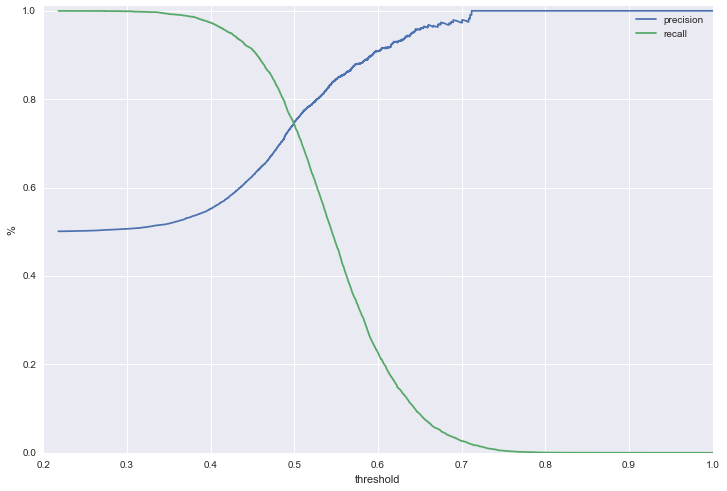

In [18]:
%matplotlib inline
Util.plot_precision_recall_curve(X, y)

## 補足 learning curve / validation curve

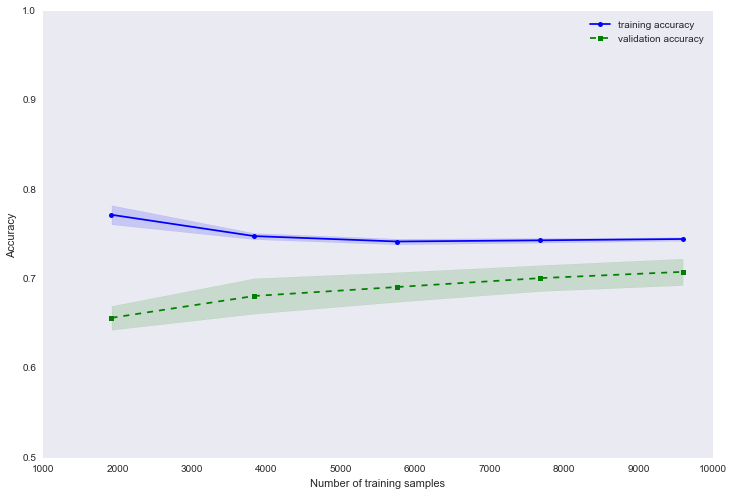

In [19]:
# learning curve
%matplotlib inline
Util.plot_learning_curve(X, y)

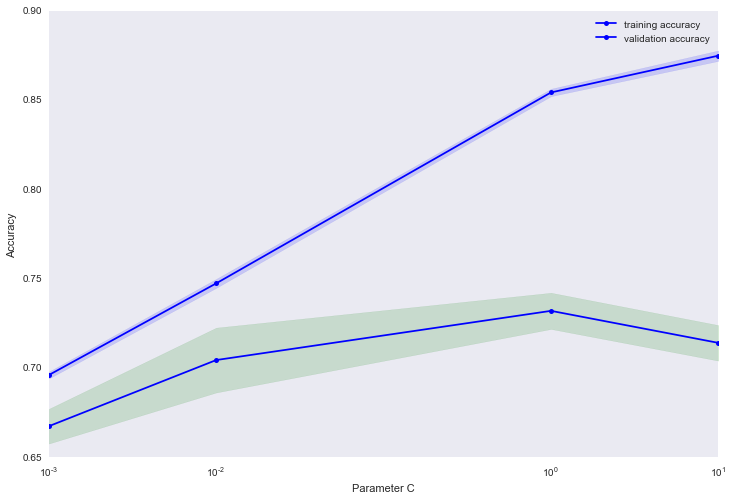

In [20]:
# validation curve
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import train_test_split

Util.plot_validation_curve(X, y)